# Proyecto planta iris

## Definición del problema

Predecir la especie de la planta iris según la longitud o ancho del sepalo y petalo de esta, es decir, un problema de clasificación multiclase.

In [96]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

plt.style.use('seaborn')

## Obtención de la data 

### Descripción de variables

El conjunto de datos posee 4 variables de entrada y una variable objetivo, las cuales son:

1. sepalo_longitud
2. sepalo_ancho
3. petalo_longitud
4. petalo_ancho
5. especies

Las 4 variables de entrada son numéricas y estan medidas en centímetros.

La variable objetivo especies es categórica y posee 3 clases:

- Iris-setosa
- Iris-versicolour
- Iris-verginica

In [164]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'

#lectura de la data
columnas = ['sepalo_longitud', 'sepalo_ancho', 'petalo_longitud', 'petalo_ancho', 'especies']

#Sépalo y Pétalo medido en centímetros cm
df = pd.read_csv(url, header=0, sep = ',', names = columnas )

df

,sepalo_longitud,sepalo_ancho,petalo_longitud,petalo_ancho,especies
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa
...,...,...,...,...,...
144,6.7,3.0,5.2,2.3,Iris-virginica
145,6.3,2.5,5.0,1.9,Iris-virginica
146,6.5,3.0,5.2,2.0,Iris-virginica
147,6.2,3.4,5.4,2.3,Iris-virginica


## Preparación de datos

### Limpieza de datos 

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepalo_longitud  149 non-null    float64
 1   sepalo_ancho     149 non-null    float64
 2   petalo_longitud  149 non-null    float64
 3   petalo_ancho     149 non-null    float64
 4   especies         149 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


#### Valores nulos

Ninguna variable cuenta con valores nulos.

In [166]:
df.isnull().sum()

sepalo_longitud    0
sepalo_ancho       0
petalo_longitud    0
petalo_ancho       0
especies           0
dtype: int64

#### Valores vacíos

Ninguna variable cuenta con valores vacíos

In [167]:
(df == '').sum()

sepalo_longitud    0
sepalo_ancho       0
petalo_longitud    0
petalo_ancho       0
especies           0
dtype: int64

#### Valores únicos

In [168]:
df.nunique()

sepalo_longitud    35
sepalo_ancho       23
petalo_longitud    43
petalo_ancho       22
especies            3
dtype: int64

#### Valores duplicados

Se procede a eliminar aquellas filas que estan duplicadas ya que es muy poco probable que 4 valores numéricos se repitan para una misma especie en una muestra relativamente pequeña, aunque no imposible.

In [169]:
df.duplicated().any()

True

In [170]:
df.drop_duplicates(inplace=True)
df.shape

(146, 5)

#### Valores atípicos (Outliers)

En los diagramas de caja realizados se puede identificar la existencia de valores atípicos en la columna **Sepalo_ancho** según el criterio del rango intercuartil (IQR)

sepalo_longitud       AxesSubplot(0.125,0.536818;0.352273x0.343182)
sepalo_ancho       AxesSubplot(0.547727,0.536818;0.352273x0.343182)
petalo_longitud          AxesSubplot(0.125,0.125;0.352273x0.343182)
petalo_ancho          AxesSubplot(0.547727,0.125;0.352273x0.343182)
dtype: object

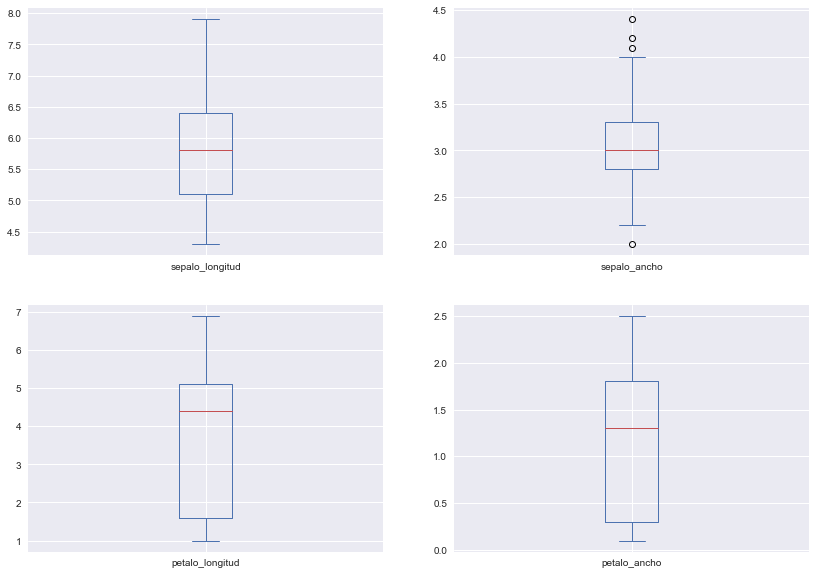

In [171]:
variables_pred = ['sepalo_longitud', 'sepalo_ancho', 'petalo_longitud', 'petalo_ancho']

df[variables_pred].plot(kind='box', subplots=True, layout=(2,2), figsize=(14,10))

In [172]:
def outlier(columna):
    
    Q1 = columna.quantile(0.25)
    
    Q3 = columna.quantile(0.75)

    IQR = Q3 - Q1

    lower, upper = Q1 - IQR * 1.5, Q3 + IQR * 1.5

    outliers = [x for x in columna if x < lower or x > upper]

    return print(outliers)

Existe un total de 4 outliers para la columna **sepalo_ancho**. Estos no serán eliminados debido a que la cantidad de datos es considerada pequeña. Además no están extremadamente alejados del resto de los datos, por lo que podría ser factible en la practica.

In [173]:
outlier(df.sepalo_ancho)

[4.4, 4.1, 4.2, 2.0]


### Análisis de variables

#### Análisis Univariable

Se analiza cada una de las variables de manera independiente.

##### Variables Numéricas

Las variables numéricas se encuentran en escalas similares, por lo que no es necesario escalar los datos.

In [174]:
df.describe()

,sepalo_longitud,sepalo_ancho,petalo_longitud,petalo_ancho
count,146.000000,146.000000,146.000000,146.000000
mean,5.861644,3.052740,3.796575,1.215753
std,0.829562,0.436948,1.753987,0.755822
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


##### Variables Categóricas

La única variable categórica corresponde a la variable objetivo **especies**. Se observa que las categorias se encuentran relativamente bien balanceadas.

In [175]:
print(df.especies.value_counts()*100/df.especies.count())

Iris-versicolor    34.246575
Iris-virginica     33.561644
Iris-setosa        32.191781
Name: especies, dtype: float64


Para seguir con los siguientes análisis se realiza la división de la data.

#### División de la data

La data sera dividida en un conjunto de entrenamiento y prueba, en donde los datos de entrenamiento corresponderan al 70% y los de prueba al 30% del total de los datos mediante el método *train_test_split*, además seran separados de tal forma que mantengan la misma proporción de especies que en la data completa para evitar sobreajustes del modelo.

In [189]:
np.random.seed(seed=1)

#Definición de variables
X = df[['sepalo_longitud', 'sepalo_ancho', 'petalo_longitud', 'petalo_ancho']]
y = df['especies']

#Separación de la data de en entrenamiento y prueba de forma aleatoría.
train_df, test_df = train_test_split(df, test_size=0.3, stratify = y)

print(train_df.shape)
print(test_df.shape)

(102, 5)
(44, 5)


#### Análisis Bivariado

Se procede a gráficar las variables numéricas para verificar visualmente posibles relaciones.

##### Gráfico de dispersión

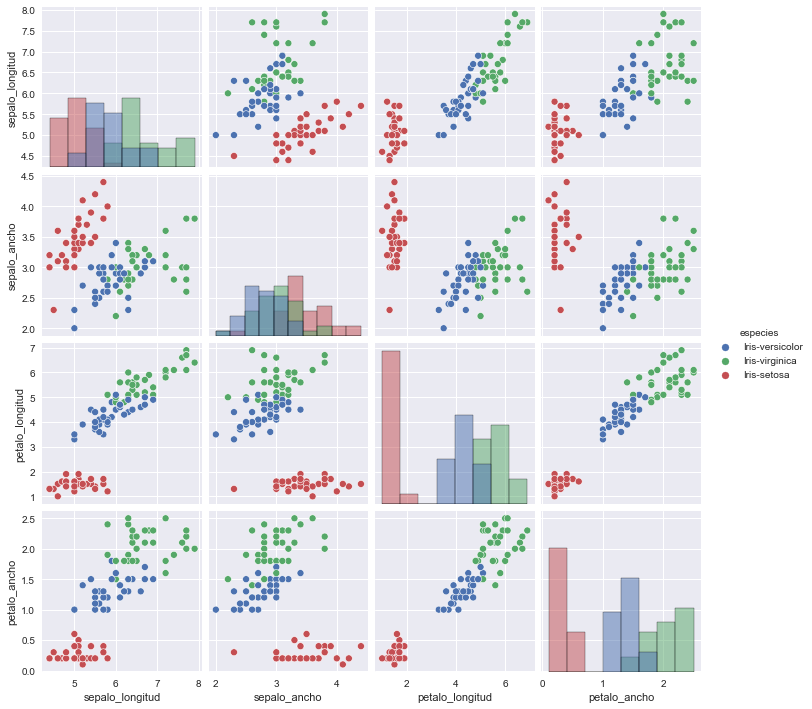

In [186]:
sns.pairplot(train_df, hue = 'especies', diag_kind = 'hist')

##### Matriz de correlaciones

De la matriz de correlaciones y los gráficos de dispersión se puede concluir que:

- **sepalo_longitud** presenta una correlación positiva con **petalo_longitud** y **petalo_ancho** en general, aunque es menos notoria para la clase *Iris Setosa*.

- No existe correlación entre **sepalo_longitud** y **sepalo_ancho** de manera general, pero al observar cada clase por separado se puede apreciar una correlación positiva.

- **sepalo_ancho** presenta una correlación negativa con **petalo_longitud** y en menor medida con **petalo_ancho**, pero para las clases *Iris versicolour* e *Iris virginica* pareciera que existe correlación positiva.

- **petalo_longitud** y **petalo_ancho** presentan una clara relación directamente proporcional que se puede observar directamente del gráfico de dispersión entre estas variables.

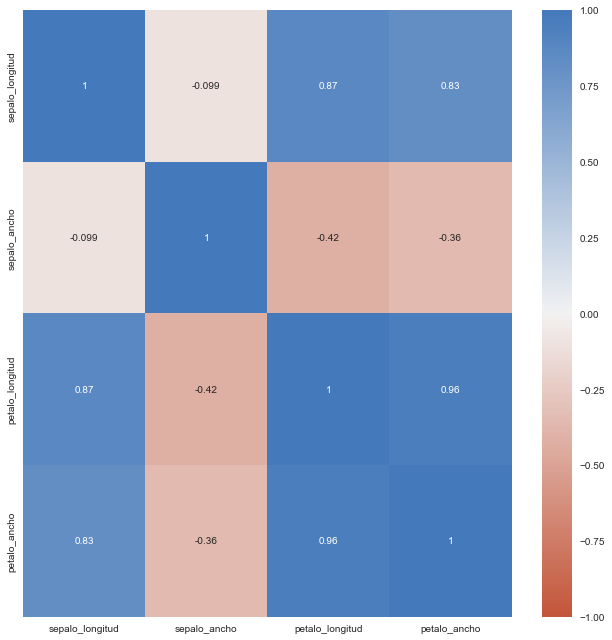

In [187]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True,
                 cmap=sns.diverging_palette(20, 250, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

### Selección de variables

Se utiliza el criterio ANOVA F-test para verificar la independencia de las variables de entrada con respecto a la variable objetivo.

sepalo_longitud 95.03247097208151
sepalo_ancho 34.162640393803464
petalo_longitud 763.6994124408924
petalo_ancho 554.8649252601566


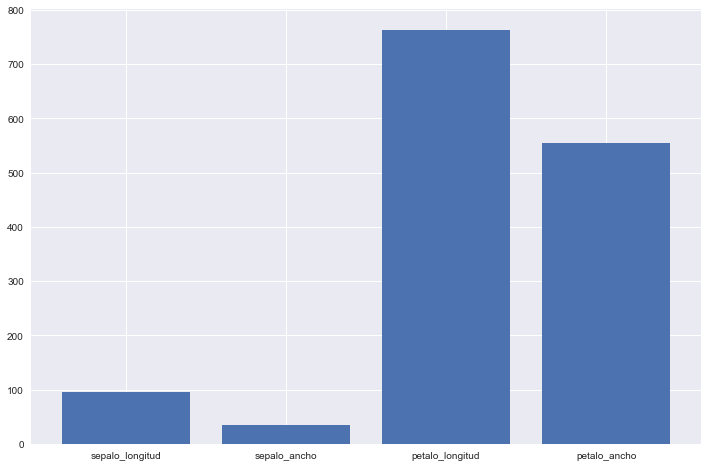

In [194]:
#Definiendo el método a utilizar
sv = SelectKBest(score_func = f_classif, k ='all')

#Ajustar las variables de entrenamiento
sv.fit(train_df[variables_pred], train_df.especies)

#Lista de scores
for i, variable in zip((range(len(sv.scores_))), variables_pred):
    print(variable, sv.scores_[i])

#Graficar scores
plt.figure(figsize = (12,8))
plt.bar([score for score in variables_pred], sv.scores_)
plt.show()

En base a lo observado las variables seleccionadas son las siguientes:

- **petalo_longitud**
- **petalo_ancho**

Uno de los principales criterios para la selección fue el grado de correlación presente entre las variables. 

La variable **petalo_longitud** y **petalo_ancho** no solo presentan una clara correlación positiva a nivel general, sino que también es posible apreciar esta relación a nivel de clases. 

Por otra parte, según el criterio ANOVA F-test estas mismas variables se consideran las mas relevantes para la variable objetivo.

In [195]:
#selección de variables en el conjunto de entrenamiento
train_X = train_df[['petalo_longitud', 'petalo_ancho']]
train_y = train_df['especies']

#selección de variables en el conjunto de prueba
test_X = test_df[['petalo_longitud', 'petalo_ancho']]
test_y = test_df['especies']

print((train_X.shape, train_y.shape))
print((test_X.shape, test_y.shape))

((102, 2), (102,))
((44, 2), (44,))


## Aplicación del modelo

Este problema corresponde a un problema de clasificación, por lo que es posible aplicar aprendizaje basados en instancias (KNN, RBF, etc.) o aprendizaje basados en modelos (LDA, regresión logística, random forest, XGBOOST, etc.).

Para este caso en particular se utilizaran dos modelos a probar KNN y XGBOOST para verificar cual se adapta mejor al problema.

### K-Nearest Neighbors

Se entrena el algoritmo de ML conocido como KNN con distintos tamaños de n_neighbors.

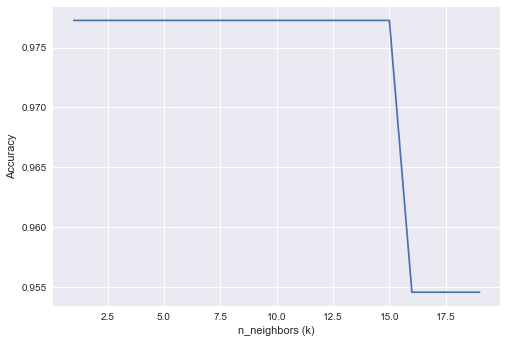

El accuracy obtenido es de: 97.727%


In [207]:
n_indice = list(range(1,20))
scores = []

for i in n_indice:
    #Se entrena el modelo con los datos de entrenamiento
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(train_X, train_y)
    
    ##Se pronóstica la variable objetivo en base al conjunto de prueba
    yhat = knn.predict(test_X)
    
    #Se determina el accuracy del modelo
    accuracy = accuracy_score(test_y, yhat)
    scores.append(accuracy)
    

plt.plot(n_indice, scores)
plt.xlabel('n_neighbors (k)')
plt.ylabel('Accuracy')
plt.show()
print('El accuracy obtenido es de: {}%'.format(round(max(scores),5)*100))

Como se puede apreciar en el gráfico, desde un k = 1 a un k = 15 se alcanza el máximo accuracy posible que equivale a un 97.73%.

### XGBOOST

Se entrena el algoritmo de ML conocido como *Extreme Gradient Boosting*(XGBOOST).

In [209]:
#Se entrena el modelo en los datos de entrenamiento
xgb_model = XGBClassifier(objective = 'multi:softprob', num_class = 3, 
                          eval_metric = 'mlogloss')
xgb_model.fit(train_X, train_y)

#Se pronóstica la variable objetivo en base al conjunto de prueba
yhat = xgb_model.predict(test_X)

#Se determina el accuracy del modelo
accuracy = accuracy_score(test_y, yhat)
print('El accuracy obtenido es de: {}%'.format(round(accuracy,5)*100))

El accuracy obtenido es de: 97.727%


#### Optimización del modelo

Mediante el RandomizedSearchCV se optimizaran los hyper-parámetros del modelo en base a la métrica **Acurracy**.

In [210]:
#Definición de parámetros
params = [{'colsample_bytree': uniform(0.1, 1), # default 1
           'learning_rate': uniform(0, 1), # Factor de contracción eta (default 0.1) 
           'max_depth': randint(2, 8), # default 3
           'n_estimators': randint(100, 400), # default 100
           'subsample': uniform(0.1, 1)}] # default 1

#Aplicación del método RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, params, n_jobs = -1, cv = 5, n_iter=200, scoring = 'accuracy', random_state=1)
random_result = random_search.fit(train_X, train_y)
print(f" Optimizando hyper-parámetros se obtiene un accuracy: {random_result.best_score_} usando {random_result.best_params_}")

 Optimizando hyper-parámetros se obtiene un accuracy: 0.9609523809523809 usando {'colsample_bytree': 0.7606357302380029, 'learning_rate': 0.2984952947530447, 'max_depth': 4, 'n_estimators': 382, 'subsample': 0.17336417174259958}


Se evalúa el modelo con los hyper-parámetros optimizados.

In [212]:
#XGBOOST optimizado
xgb_model_op = random_result.best_estimator_

#Se pronóstican los y en base al conjunto de prueba
yhat_op = xgb_model_op.predict(test_X)

#Se determina el accuracy del modelo con hyper-parámetros optimizados
accuracy = accuracy_score(test_y, yhat_op)
print('El accuracy obtenido con hyper-parámetros optimizados: {}%'.format(round(accuracy,5)*100))

El accuracy obtenido con hyper-parámetros optimizados: 97.727%


## Selección del modelo

Basandonos en la métrica **accuracy** ambos modelos obtienen el mismo resultado, inclusive el modelo XGBOOST a pesar de ser optimizado no presenta ninguna mejoría. Por otro lado, el modelo kNN presenta el mismo rendimiento para un rango de k = [1, 15].

El modelo escogido sera el XGBOOST, ya que con respecto al modelo kNN no se sabe con seguridad que k escoger para predecir nuevos datos.

Además se debe destacar que basta con conocer las variables **petalo_longitud** y **petalo_ancho** de una planta iris para determinar el tipo de especie a la cual corresponde con un alto margen de precisión. Por esta razón se concluye que estas variables son características determinantes de cada **especie**.

Por último, se debe destacar que la selección de variables en este caso en particular no es necesaria debido al tamaño de la base de datos, pero de igual forma fue llevada a cabo para optimizar la velocidad de ejecución del modelo, ya que una vez desplegado no se tiene conocimiento de cuantos datos nuevos puedan ser ingresados.

In [213]:
import session_info
session_info.show()